In [ ]:
# init repo notebook
!git clone https://github.com/rramosp/ppdl.git > /dev/null 2> /dev/null
!mv -n ppdl/content/init.py ppdl/content/local . 2> /dev/null
!pip install -r ppdl/content/requirements.txt > /dev/null

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras.optimizers import Adam
from IPython.display import display, Math
plt.style.use("ggplot")

In [3]:
tfd = tfp.distributions

## Probabilistic Linear Regression
---

The linear regression is one of the simplest models in machine learning, the main goal is to compute an estimation $\tilde{\mathbf{y}} \in \mathbb{R} ^ N$ (where $N$ is the number of samples) of a target variable $\mathbf{y} \in \mathbb{R} ^ N$ using some input variables $\mathbf{X} \in \mathbb{R} ^ {N \times m}$ (where $m$ is the number of variables) through a linear model:

$$
\tilde{\mathbf{y}} =  \mathbf{x} \cdot \mathbf{w}
$$

Conventionally, the parameters $\mathbf{w} \in \mathbb{R} ^ m$ are estimated through the minimization of the Mean Squared Error (MSE). However, this is equivalent to the Maximum Likelihood Estimation (MLE) of a probabilistic model. More precisely, we assume that the distribution of the label's noise is given by a normal distribution, so it is possible to define the following model:

$$
\begin{split}
\mathbf{y} &= \mathbf{\tilde{y}} + \epsilon\\
\mathbf{y} &= \mathbf{X} \cdot \mathbf{w} + \epsilon
\end{split}
$$

Where $\epsilon \sim \mathcal{N}(\mu = 0, \sigma=E)$ and $E$ is the noise's magnitude or standard error. This can be summarized as the distribution of the target variables as follows:

$$
P(\mathbf{y} | \mathbf{X}, \mathbf{w}, E) = \mathcal{N}(\mathbf{y} = \mathbf{X} \cdot \mathbf{w}, \sigma=E)
$$

The MLE would then consist on determining $\mathbf{w}$ and $E$ such that the likelihood probability is maximized, or equivalently, minimizing the negative log-likelihood.

Let's see an example over some synthetic data:

In [5]:
x = tf.random.uniform(
        shape = (1000, 1),
        minval = -1,
        maxval = 1
        )
X = tf.concat([x, tf.ones_like(x)], axis=1)
display(Math(r"\mathbf{X}:"))
display(X[:5])
display(X.shape)

<IPython.core.display.Math object>

<tf.Tensor: shape=(5, 2), dtype=float32, numpy=
array([[-0.45172   ,  1.        ],
       [ 0.99588037,  1.        ],
       [-0.58632326,  1.        ],
       [-0.69879675,  1.        ],
       [-0.72001743,  1.        ]], dtype=float32)>

TensorShape([1000, 2])

Let's assume the following values for $\mathbf{w}$ and $E$:

In [6]:
w_real = tf.constant([[1.0], [-1.0]])
e_real = tf.constant(0.1)
display(Math(r"\mathbf{w}:"))
display(w_real)
display(Math(r"E:"))
display(e_real)

<IPython.core.display.Math object>

<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[ 1.],
       [-1.]], dtype=float32)>

<IPython.core.display.Math object>

<tf.Tensor: shape=(), dtype=float32, numpy=0.1>

Using these theoretical values, We can generate the $\mathbf{y}$ values:

In [7]:
y = X @ w_real + tf.random.normal(shape=(1000, 1), mean=0, stddev=e_real)
display(Math(r"\mathbf{y}:"))
display(y[:5])
display(y.shape)

<IPython.core.display.Math object>

<tf.Tensor: shape=(5, 1), dtype=float32, numpy=
array([[-1.6190988 ],
       [ 0.06170123],
       [-1.4506689 ],
       [-1.6691394 ],
       [-1.7425723 ]], dtype=float32)>

TensorShape([1000, 1])

We can visualize the generated dataset:

/tmp/ipykernel_773471/3821964282.py:5: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


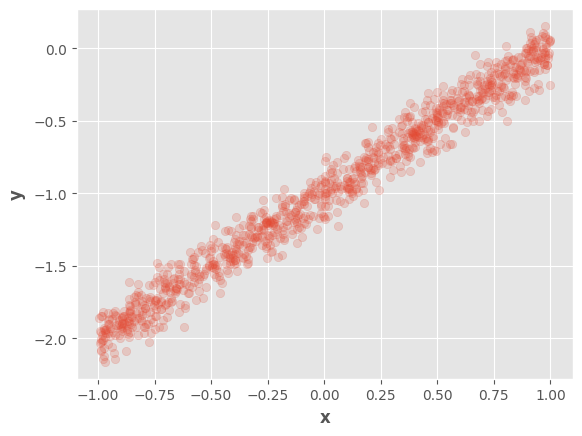

In [8]:
fig, ax = plt.subplots()
ax.scatter(tf.squeeze(x), tf.squeeze(y), alpha=0.2)
ax.set_xlabel(r"$\mathbf{x}$")
ax.set_ylabel(r"$\mathbf{y}$")
fig.show()

For the estimation of these values We'll use the automatic differentiation of `tensorflow`, to this end, we must define an initial set of parameters:

In [9]:
w = tf.Variable([[0.0], [0.0]])
e = tf.Variable(1.0)

Now, We can define a `tensorflow_probability` distribution:

In [10]:
dist = tfd.Normal(loc=X @ w, scale=e)
display(dist)

<tfp.distributions.Normal 'Normal' batch_shape=[1000, 1] event_shape=[] dtype=float32>

Let's define the training loop:

In [11]:
n_iters = 100
optimizer = Adam(learning_rate=1e-2)
training_variables = [w, e]
for i in range(n_iters):
    with tf.GradientTape() as t:
        dist = tfd.Normal(loc=X @ w, scale=e)
        nll = -tf.reduce_sum(dist.log_prob(y))
        grads = t.gradient(nll, training_variables)
        optimizer.apply_gradients(zip(grads, training_variables))

We can compare the real parameters $\mathbf{w}$ and the estimated ones $\tilde{\mathbf{w}}$

In [12]:
display(Math(r"\mathbf{w}"))
display(w_real)
display(Math(r"\tilde{\mathbf{w}}"))
display(w)

<IPython.core.display.Math object>

<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[ 1.],
       [-1.]], dtype=float32)>

<IPython.core.display.Math object>

<tf.Variable 'Variable:0' shape=(2, 1) dtype=float32, numpy=
array([[ 1.0003284],
       [-0.9978788]], dtype=float32)>

Also the noise's magnitude $E$ and the estimated one $\tilde{E}$

In [13]:
display(Math(r"E"))
display(e_real)
display(Math(r"\tilde{E}"))
display(e)

<IPython.core.display.Math object>

<tf.Tensor: shape=(), dtype=float32, numpy=0.1>

<IPython.core.display.Math object>

<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.12940276>

As you can see, it's a valid probabilistic model. We can generate predictions from it:

In [14]:
x_test = tf.cast(
        tf.reshape(tf.linspace(start=-1, stop=1, num=100), (-1, 1)),
        tf.float32
        )
X_test = tf.concat([x_test, tf.ones_like(x_test)], axis=1)
y_pred = X_test @ w
y_pred_high = y_pred + 3 * tf.ones_like(y_pred) * e
y_pred_low = y_pred - 3 * tf.ones_like(y_pred) * e

Let's visualize the predictions:

/tmp/ipykernel_773471/2646422756.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


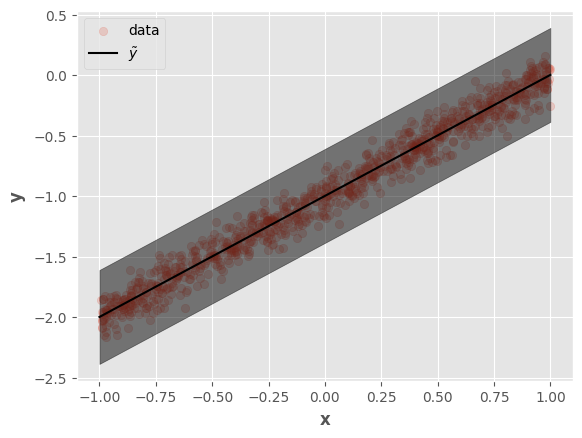

In [16]:
fig, ax = plt.subplots()
ax.scatter(tf.squeeze(x), tf.squeeze(y), alpha=0.2, label="data")
ax.plot(tf.squeeze(x_test), tf.squeeze(y_pred), label=r"$\tilde{y}$", color="k")
ax.fill_between(
    tf.squeeze(x_test),
    tf.squeeze(y_pred_low),
    tf.squeeze(y_pred_high),
    alpha=0.5, color="k"
)
ax.set_xlabel(r"$\mathbf{x}$")
ax.set_ylabel(r"$\mathbf{y}$")
ax.legend()
fig.show()